In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import textblob
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
data = pd.read_csv("dataset.csv", delimiter=";",usecols=["star_rating", "review_body"])
# Null value control.
print("Before delete null values\n",data.isna().sum())
data.dropna(inplace=True)
data.index = range(1, len(data)+1)
print("\nAfter delete null values\n",data.isna().sum())
print("\nShape of our dataset:",data.shape)
data.head()

Before delete null values
 star_rating     0
review_body    12
dtype: int64

After delete null values
 star_rating    0
review_body    0
dtype: int64

Shape of our dataset: (102072, 2)


,star_rating,review_body
1,4,So far so good
2,3,Needs a little more work.....
3,1,Please cancel.
4,5,Works as Expected!
5,4,I've had Webroot for a few years. It expired a...


Veri inceleme

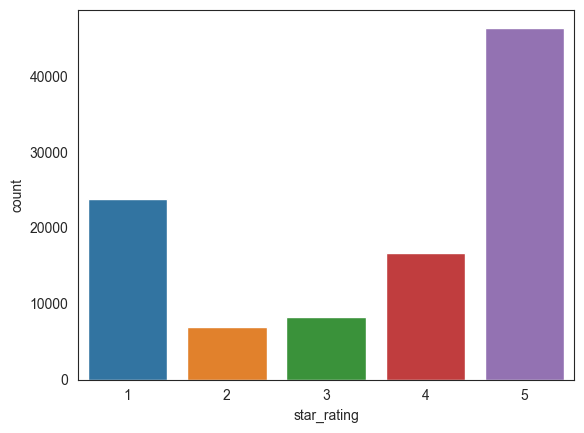

In [3]:
#Countplot
data['sentiment'] = data['star_rating'].map({1.0:'Negative', 2.0:'Negative',
                                     3.0: 'Neutral',4.0:'Positive',
                                     5.0:'Positive'})

                                    
import seaborn as sns
sns.set_style("white")
sns.countplot(x ='star_rating', data = data)
plt.show()

In [4]:
# Delete star_rating = 3, because they are notr.
data.drop(axis=0, index=data[data["star_rating"] == 3].index, inplace=True)
data.index = range(1, len(data)+1)

In [5]:
np.random.seed(1027)
delete_pos = []
delete_pos = data[data["sentiment"] == "Positive"].index
delete_pos = np.random.choice(delete_pos, size = 51000, replace=False)
delete_pos.sort()

delete_neg = []
delete_neg = data[data["sentiment"] == "Negative"].index
delete_neg = np.random.choice(delete_neg, size = 20000, replace=False)
delete_neg.sort()

data = data.drop(axis=0, index=delete_pos)
data = data.drop(axis=0, index=delete_neg)
data.index = range(1, len(data)+1)

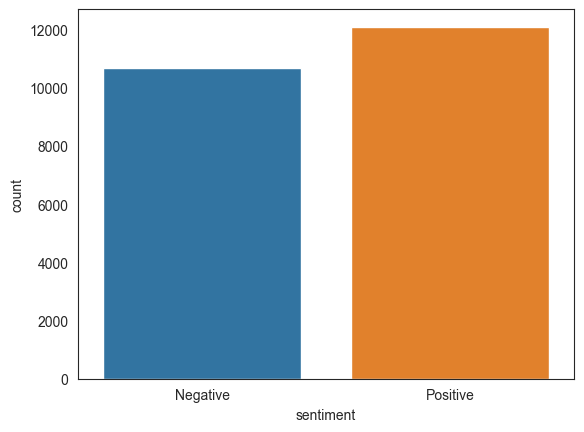

sentiment
Positive    12097
Negative    10667
Name: count, dtype: int64

In [6]:
sns.set_style("white")
sns.countplot(x ='sentiment', data = data)
plt.show()
data["sentiment"].value_counts()

In [7]:
#Copied dataset.
df = data.copy()

Text Preprocessing

In [8]:
# star_rating columns silme
df = df.drop("star_rating", axis=1)
# review_body columns adını review olarak değiştirilmesi
df = df.rename(columns={"review_body": "review"})
# Sentiment columnsu 1 ve 0 olarak değiştirilmesi
df["sentiment"] = df["sentiment"].map({"Positive": 1, "Negative": 0})
# review columns str tipine dönüştürme
df["review"] = df["review"].astype(str)
# Küçük harf dönüşümü
df["review"] = df["review"].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Noktalama işaretlerinin ve html kodlarının silinmesi
df["review"] = df["review"].apply(lambda x: re.sub('<br>', '', x))
df["review"] = df["review"].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
# Sayıların Temizlenmesi
df['review'] = df['review'].apply(lambda x: re.sub(r'\d+', '', x))
# Boşlukların silinmesi
df["review"] = df["review"].apply(lambda x: " ".join(x.split()))


Stopwordslerin Temizlenmesi

In [9]:
sw = set(stopwords.words("english"))
sw.add("br")
sw.add("ive")
sw 

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'ive',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'ove

In [10]:
df["review_cleaned"] = df.review.str.split(" ")
df.review_cleaned = df.review_cleaned.apply(lambda x: [i for i in x if i not in sw])
df.head()

,review,sentiment,review_cleaned
1,please cancel,0,"[please, cancel]"
2,works as expected,1,"[works, expected]"
3,waste of time,0,"[waste, time]"
4,purchased this on sell got pc installment for ...,1,"[purchased, sell, got, pc, installment, norton..."
5,thought this included search with it and no it...,0,"[thought, included, search, added, fees, every..."


In [11]:
# Metinleri Birleştirme
text_combined = ' '.join(df['review_cleaned'].sum())

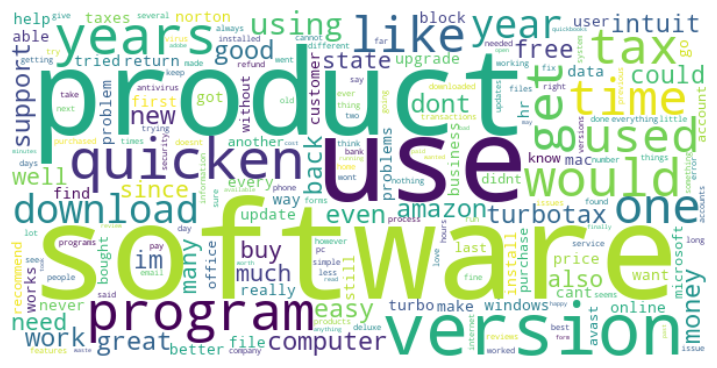

In [12]:
# Kelime frekanslarını hesaplama
word_freq = {}
words = text_combined.lower().split()
for word in words:
    if word not in word_freq:
        word_freq[word] = 1
    else:
        word_freq[word] += 1

# Word cloud oluşturma
wordcloud = WordCloud(width=600, height=300, background_color="white").generate_from_frequencies(word_freq)

# Word cloud'ı görselleştirme
plt.figure(figsize=(9, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Lemmatization

In [13]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """POS tagger kullanarak kelime türünü belirleme"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    """Verilen metni lemmatize ederek geri döndürme"""
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text


df['lemmatized'] = df['review_cleaned'].apply(lambda x: lemmatize_text(' '.join(x)))


Machine Learning and Creating a Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [15]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df.lemmatized).toarray()
y = df.sentiment
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.22327916, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_res = LogisticRegression()
log_res.fit(X_train, y_train)
y_pred = log_res.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

log_accuracy = accuracy_score(y_test, y_pred)

0.8899626619811114
[[1883  244]
 [ 257 2169]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2127
           1       0.90      0.89      0.90      2426

    accuracy                           0.89      4553
   macro avg       0.89      0.89      0.89      4553
weighted avg       0.89      0.89      0.89      4553



In [17]:
# Random Forests
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

rf_accuracy = accuracy_score(y_test, y_pred)


0.8559191741708764
[[1861  266]
 [ 390 2036]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2127
           1       0.88      0.84      0.86      2426

    accuracy                           0.86      4553
   macro avg       0.86      0.86      0.86      4553
weighted avg       0.86      0.86      0.86      4553



In [18]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

nb_accuracy = accuracy_score(y_test, y_pred)


0.7131561607731166
[[1160  967]
 [ 339 2087]]
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      2127
           1       0.68      0.86      0.76      2426

    accuracy                           0.71      4553
   macro avg       0.73      0.70      0.70      4553
weighted avg       0.73      0.71      0.70      4553



In [19]:
# SGD Classifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
y_pred = sgd_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

sgd_accuracy = accuracy_score(y_test, y_pred)


0.8893037557654294
[[1875  252]
 [ 252 2174]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2127
           1       0.90      0.90      0.90      2426

    accuracy                           0.89      4553
   macro avg       0.89      0.89      0.89      4553
weighted avg       0.89      0.89      0.89      4553



In [20]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

dt_accuracy = accuracy_score(y_test, y_pred)


0.7851965736876785
[[1627  500]
 [ 478 1948]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      2127
           1       0.80      0.80      0.80      2426

    accuracy                           0.79      4553
   macro avg       0.78      0.78      0.78      4553
weighted avg       0.79      0.79      0.79      4553



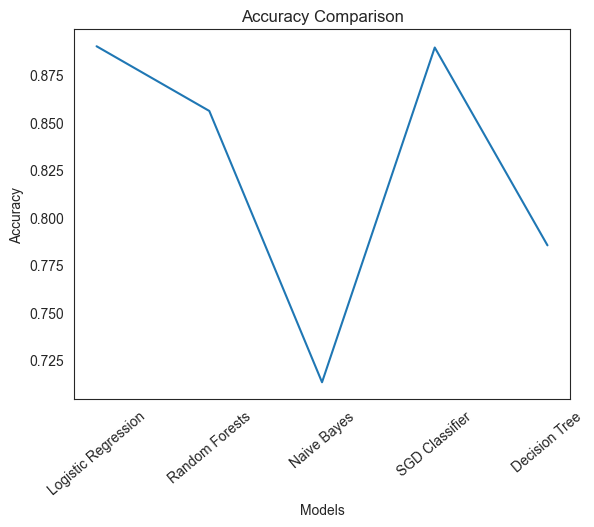

In [21]:
#Accuracy diagram
models = ['Logistic Regression', 'Random Forests', 'Naive Bayes', 'SGD Classifier','Decision Tree']
accuracy = [log_accuracy, rf_accuracy, nb_accuracy, sgd_accuracy, dt_accuracy]

plt.plot(models, accuracy)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=40)
plt.show()